# Flow fitting
Use flow sensors' data (ground truth), HERE speed records, and OSM data to compute the estimated flow.

In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import os
import subprocess
import sys
def get_repo_root():
    """Get the root directory of the repo."""
    dir_in_repo = os.path.dirname(os.path.abspath('__file__')) # os.getcwd()
    return subprocess.check_output('git rev-parse --show-toplevel'.split(),
                                   cwd=dir_in_repo,
                                   universal_newlines=True).rstrip()
sys.path.append(get_repo_root())
ROOT_dir = get_repo_root()

def flow_cal(X, alpha=None, beta=None):
    """
    Function to get flow by using speed, free-flow speed, and capacity
    :param X: an array, [[speed, free-flow speed, capacity]...]
    :param alpha: BPR parameter
    :param beta: BPR parameter
    :return: estimated flow
    """
    return X[:, 2]*((X[:, 1]/X[:, 0] - 1) / alpha)**(1/beta)

In [31]:
import pandas as pd
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

df = pd.read_csv(ROOT_dir + '/dbs/flow3m.csv')
df.head()

## 1. Test a road segment with two functions for its two directions

In [24]:
df = df.loc[(df.speed != 0) & (df.speed_ff > df.speed), :]
r = list(df.groupby(['HERE_segID', 'direction']))
df_road = r[0][1]
df_road.head()

,time,sensor,HERE_segID,flow,speed,speed_ff,osm_id,direction,oneway,lanes,capacity
1072323,2018-02-01 06:00:00,6086,2_10122,262,26.86,36.0,5726427,0,0,1,700
1072326,2018-02-01 07:00:00,6086,2_10122,873,22.26,36.0,5726427,0,0,1,700
1072329,2018-02-01 08:00:00,6086,2_10122,683,22.30,41.0,5726427,0,0,1,700
1072332,2018-02-01 09:00:00,6086,2_10122,772,22.60,36.0,5726427,0,0,1,700
1072335,2018-02-01 10:00:00,6086,2_10122,732,27.24,41.0,5726427,0,0,1,700


In [22]:
X = df_road.loc[:, ['speed', 'speed_ff', 'capacity']].values
y = df_road.flow.values
popt, _ = curve_fit(flow_cal, X, y)
r2 = r2_score(y, flow_cal(X, *popt))

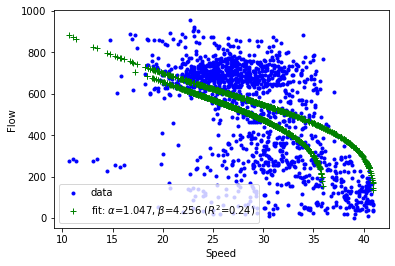

In [23]:
plt.plot(df_road.speed, y, 'b.', label='data')
plt.plot(df_road.speed, flow_cal(X, *popt), 'g+',
         label="fit: $\\alpha$=%5.3f, $\\beta$=%5.3f ($R^2$=%3.2f)" % tuple([x for x in popt] + [r2]))
plt.xlabel('Speed')
plt.ylabel('Flow')
plt.legend()
plt.show()


## 2. Iterate over road segment x direction

In [26]:
df_list = []
params = []
for ele in r:
    # Take a road seg direction to fit with the model
    t = ele[1]
    X = t.loc[:, ['speed', 'speed_ff', 'capacity']].values
    y = t.flow.values
    popt, _ = curve_fit(flow_cal, X, y, bounds=[(0.01, 1), (0.99, 10)])
    y_fit = flow_cal(X, *popt)
    r2 = r2_score(y, y_fit)
    t.loc[:, 'flow_fit'] = y_fit
    df_list.append(t)
    params.append(tuple([x for x in ele[0]] + [x for x in popt] + [r2]))
df_n = pd.concat(df_list)
df_para = pd.DataFrame(params, columns=['HERE_segID', 'direction', 'alpha', 'beta', 'r2'])
df_n.head()

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\yuanlia\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\yuanlia\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_regression

,time,sensor,HERE_segID,flow,speed,speed_ff,osm_id,direction,oneway,lanes,capacity,flow_fit
1072323,2018-02-01 06:00:00,6086,2_10122,262,26.86,36.0,5726427,0,0,1,700,540.273941
1072326,2018-02-01 07:00:00,6086,2_10122,873,22.26,36.0,5726427,0,0,1,700,624.219545
1072329,2018-02-01 08:00:00,6086,2_10122,683,22.30,41.0,5726427,0,0,1,700,672.375734
1072332,2018-02-01 09:00:00,6086,2_10122,772,22.60,36.0,5726427,0,0,1,700,618.160900
1072335,2018-02-01 10:00:00,6086,2_10122,732,27.24,41.0,5726427,0,0,1,700,594.600270


In [27]:
# Check the parameters
df_para.head()

,HERE_segID,direction,alpha,beta,r2
0,2_10122,0,0.990000,4.123208,0.240866
1,2_10122,1,0.565439,2.223576,0.497532
2,2_10131,0,0.990000,1.075335,-3.012580
3,2_10131,1,0.990000,1.000000,-3.233923
4,2_10136,0,0.990000,1.359145,-0.850551


In [34]:
len(df_para.loc[df_para.r2 >0, :]) / len(df_para)
df_para.to_csv(ROOT_dir + '/results/params.csv', index=False)
df_n.to_csv(ROOT_dir + '/dbs/flow3m_estimated.csv', index=False)

## 3. Find a single parameter set for all

In [33]:
# Take a road seg direction to fit with the model
X = df.loc[:, ['speed', 'speed_ff', 'capacity']].values
y = df.flow.values
popt, _ = curve_fit(flow_cal, X, y, bounds=[(0.01, 1), (0.99, 10)])
y_fit = flow_cal(X, *popt)
r2 = r2_score(y, y_fit)
mse = mean_squared_error(y, y_fit)
df.loc[:, 'flow_fit'] = y_fit
print("Parameters:", tuple([x for x in popt] + [r2, mse]))

Parameters: (0.9899999999999999, 2.334466930963126, -2.982804044056016, 1890684.8375550467)
